# Effect of different schedules on Expected Shortfall

## Balanced sectoral weighing

### Parameters

J = 3; N_firms = 1000

c = 0.01

r = 0.12
N = 12

5000 Monte Carlo Trials

### LGD = 1

In [6]:
import numpy as np
import scipy
from scipy.stats import ncx2
from scipy.special import hyp1f1
from scipy.optimize import brentq
from math import exp
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import kurtosis

DECIMALS = 6

np.set_printoptions(precision=DECIMALS, suppress=True)
pd.options.display.float_format = lambda x: f"{x:.{DECIMALS}f}"
pd.set_option("display.precision", DECIMALS)

In [ ]:
from ipynb.fs.defs.amortisation import *

In [8]:
rng = np.random.default_rng(1265883927568217)

N_firms = 1000
J = 3

c = 0.01

T = 1

NUM_TRIALS = 5000

kappa = rng.uniform(0.5, 1.5, J)
theta = rng.uniform(0.001, 0.051, J)
sigma_inter = rng.uniform(0.0, 0.2, J)
sigma = np.minimum(np.sqrt(2*kappa*theta), sigma_inter)

idio_factor = rng.uniform(0.01, 0.03, N_firms)

feller = (2 * kappa * theta) / (sigma**2)
print("Feller condition (should be >=1):", feller)

W = generate_portfolio_weights(N_firms, J, "balanced", rng=rng)

delta = c * W

lambda_benchmark = np.array([
    lambda_max_generator(1e-4, theta[j], theta[j],
                         sigma[j], kappa[j])
    for j in range(J)
])


params = {
    'Firms': N_firms,
    'Sectors': J,
    'Global Senstivity Param': c,
    'kappa': kappa,
    'theta': theta,
    'sigma': sigma,
    'delta': delta,
    'lambda_benchmark': lambda_benchmark,
    'idio_factor': idio_factor,
    'W': W,
    'T': T
}

Feller condition (should be >=1): [3.637663 4.700201 5.508869]


In [9]:
params_df = pd.DataFrame({
    'kappa': kappa,
    'theta': theta,
    'sigma': sigma,
    'lambda_benchmark': lambda_benchmark
}, index=[f'Sector_{j}' for j in range(J)])

print("Parameters per Sector:")
print(params_df)

print("\n\nPortfolio Weights (W):")
W_df = pd.DataFrame(W, columns=[f'Sector_{j}' for j in range(J)], index=pd.Index(range(N_firms), name='Firm'))
print(W_df)

Parameters per Sector:
            kappa    theta    sigma  lambda_benchmark
Sector_0 0.694378 0.048318 0.135817          0.259574
Sector_1 1.121571 0.049001 0.152923          0.229543
Sector_2 1.408060 0.014160 0.085078          0.076515


Portfolio Weights (W):
      Sector_0  Sector_1  Sector_2
Firm                              
0     0.333333  0.333333  0.333333
1     0.333333  0.333333  0.333333
2     0.333333  0.333333  0.333333
3     0.333333  0.333333  0.333333
4     0.333333  0.333333  0.333333
...        ...       ...       ...
995   0.333333  0.333333  0.333333
996   0.333333  0.333333  0.333333
997   0.333333  0.333333  0.333333
998   0.333333  0.333333  0.333333
999   0.333333  0.333333  0.333333

[1000 rows x 3 columns]


## Bullet Loan
repayment where the outstanding principal is repaid in full at the time of "maturity" (default).

              Mean        Std         VaR          ES  Excess ES  \
Bullet 2270.990000 484.912899 3120.000000 3305.787402 185.787402   

        ExcessKurtosis  
Bullet       -0.174923  


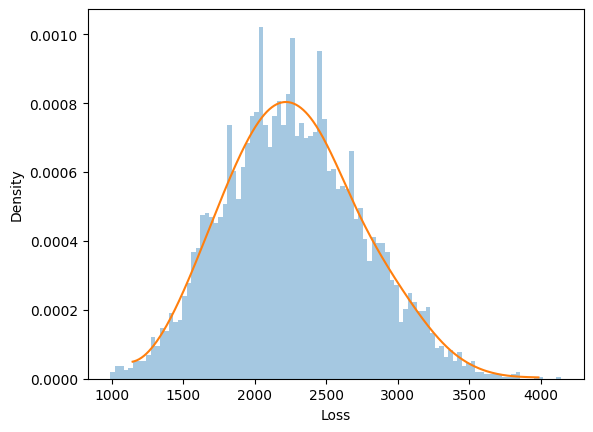

In [10]:
loan_b = [
    {
        "type": 'bullet',
        "P": 10.0,
        "N": 12,
        "r": 0.12,
    }
    for i in range(N_firms)
]

losses_b = run_simulation(params, loan_b, num_trials=NUM_TRIALS)
metrics_b = compute_metrics(losses_b, alpha=0.95)
metrics_b_df = pd.DataFrame(metrics_b, index=['Bullet'])
print(metrics_b_df)

loss_distribution_plot(losses_b, 'Bullet Loan')

## French amortisation
repayment scheme where a constant total installment (Principal + Interest) throughout the life of the loan is paid

             Mean        Std        VaR          ES  Excess ES  ExcessKurtosis
French 667.553590 152.824490 933.081822 1010.468643  77.386821        0.155837


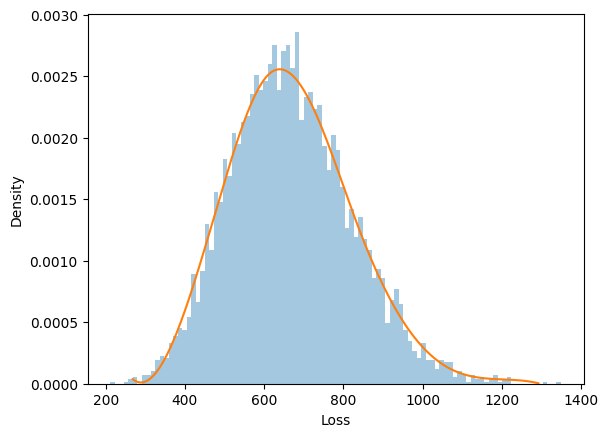

In [11]:
loan_f = [
    {
        "type": 'french',
        "P": 10.0,
        "N": 12,
        "r": 0.12,
    }
    for i in range(N_firms)
]

losses_f = run_simulation(params, loan_f, num_trials=NUM_TRIALS)
metrics_f = compute_metrics(losses_f, alpha=0.95)
metrics_f_df = pd.DataFrame(metrics_f, index=['French'])
print(metrics_f_df)

loss_distribution_plot(losses_f, 'French scheme')

## Linear (Italian) amortisation
repayment scheme characterised by a constant repayment of principal in each installment.

             Mean        Std        VaR         ES  Excess ES  ExcessKurtosis
Linear 647.897333 147.974479 905.833333 986.977513  81.144180        0.255126


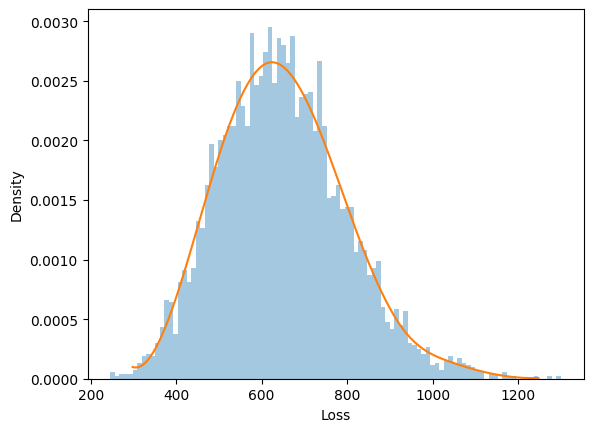

In [12]:
loan_l = [
    {
        "type": 'linear',
        "P": 10.0,
        "N": 12,
        "r": 0.12,
    }
    for i in range(N_firms)
]

losses_l = run_simulation(params, loan_l, num_trials=NUM_TRIALS)
metrics_l = compute_metrics(losses_l, alpha=0.95)
metrics_l_df = pd.DataFrame(metrics_l, index=['Linear'])
print(metrics_l_df)

loss_distribution_plot(losses_l, 'Linear amortisation')

In [13]:
balancedsectors_df = pd.concat([metrics_b_df, metrics_f_df, metrics_l_df])
balancedsectors_df

,Mean,Std,VaR,ES,Excess ES,ExcessKurtosis
Bullet,2270.990000,484.912899,3120.000000,3305.787402,185.787402,-0.174923
French,667.553590,152.824490,933.081822,1010.468643,77.386821,0.155837
Linear,647.897333,147.974479,905.833333,986.977513,81.144180,0.255126


## Concentrated sectoral weighing

In [14]:
rng = np.random.default_rng(1265883927568217)

N_firms = 1000
J = 3

c = 0.01

T = 1

NUM_TRIALS = 5000

kappa = rng.uniform(0.5, 1.5, J)
theta = rng.uniform(0.001, 0.051, J)
sigma_inter = rng.uniform(0.0, 0.2, J)
sigma = np.minimum(np.sqrt(2*kappa*theta), sigma_inter)

idio_factor = rng.uniform(0.01, 0.03, N_firms)

feller = (2 * kappa * theta) / (sigma**2)
print("Feller condition (should be >=1):", feller)

W = generate_portfolio_weights(N_firms, J, "concentrated", rng=rng)

delta = c * W

lambda_benchmark = np.array([
    lambda_max_generator(1e-4, theta[j], theta[j],
                         sigma[j], kappa[j])
    for j in range(J)
])


params = {
    'Firms': N_firms,
    'Sectors': J,
    'Global Senstivity Param': c,
    'kappa': kappa,
    'theta': theta,
    'sigma': sigma,
    'delta': delta,
    'lambda_benchmark': lambda_benchmark,
    'idio_factor': idio_factor,
    'W': W,
    'T': T
}

Feller condition (should be >=1): [3.637663 4.700201 5.508869]


In [15]:
params_df = pd.DataFrame({
    'kappa': kappa,
    'theta': theta,
    'sigma': sigma,
    'lambda_benchmark': lambda_benchmark
}, index=[f'Sector_{j}' for j in range(J)])

print("Parameters per Sector:")
print(params_df)

print("\n\nPortfolio Weights (W):")
W_df = pd.DataFrame(W, columns=[f'Sector_{j}' for j in range(J)], index=pd.Index(range(N_firms), name='Firm'))
print(W_df)

Parameters per Sector:
            kappa    theta    sigma  lambda_benchmark
Sector_0 0.694378 0.048318 0.135817          0.259574
Sector_1 1.121571 0.049001 0.152923          0.229543
Sector_2 1.408060 0.014160 0.085078          0.076515


Portfolio Weights (W):
      Sector_0  Sector_1  Sector_2
Firm                              
0     0.700000  0.150000  0.150000
1     0.700000  0.150000  0.150000
2     0.700000  0.150000  0.150000
3     0.700000  0.150000  0.150000
4     0.700000  0.150000  0.150000
...        ...       ...       ...
995   0.700000  0.150000  0.150000
996   0.700000  0.150000  0.150000
997   0.700000  0.150000  0.150000
998   0.700000  0.150000  0.150000
999   0.700000  0.150000  0.150000

[1000 rows x 3 columns]


## Bullet Loan
repayment where the outstanding principal is repaid in full at the time of "maturity" (default).

              Mean        Std         VaR          ES  Excess ES  \
Bullet 5885.982000 808.605835 7100.500000 7320.680000 220.180000   

        ExcessKurtosis  
Bullet        0.119520  


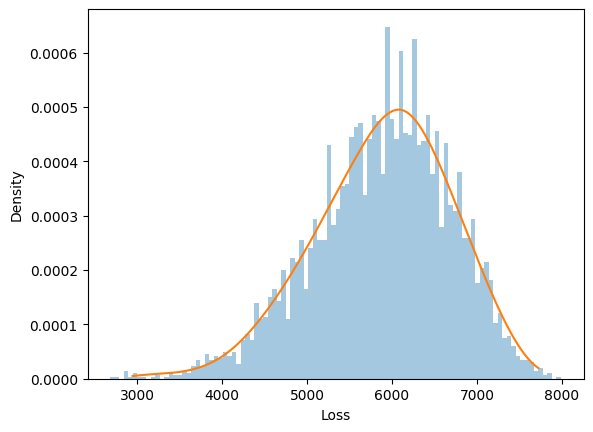

In [16]:
loan_b = [
    {
        "type": 'bullet',
        "P": 10.0,
        "N": 12,
        "r": 0.12,
    }
    for i in range(N_firms)
]

losses_b = run_simulation(params, loan_b, num_trials=NUM_TRIALS)
metrics_b = compute_metrics(losses_b, alpha=0.95)
metrics_b_df = pd.DataFrame(metrics_b, index=['Bullet'])
print(metrics_b_df)

loss_distribution_plot(losses_b, 'Bullet Loan')

## French amortisation
repayment scheme where a constant total installment (Principal + Interest) throughout the life of the loan is paid

              Mean        Std         VaR          ES  Excess ES  \
French 1347.797183 338.077817 1928.877788 2097.959395 169.081607   

        ExcessKurtosis  
French        0.055993  


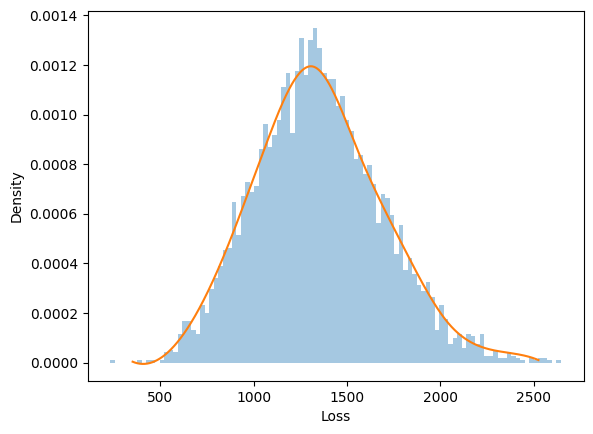

In [17]:

loan_f = [
    {
        "type": 'french',
        "P": 10.0,
        "N": 12,
        "r": 0.12,
    }
    for i in range(N_firms)
]

losses_f = run_simulation(params, loan_f, num_trials=NUM_TRIALS)
metrics_f = compute_metrics(losses_f, alpha=0.95)
metrics_f_df = pd.DataFrame(metrics_f, index=['French'])
print(metrics_f_df)

loss_distribution_plot(losses_f, 'French scheme')


## Linear (Italian) amortisation
repayment scheme characterised by a constant repayment of principal in each installment.


              Mean        Std         VaR          ES  Excess ES  \
Linear 1287.381000 320.833390 1843.333333 1991.928951 148.595618   

        ExcessKurtosis  
Linear       -0.037059  


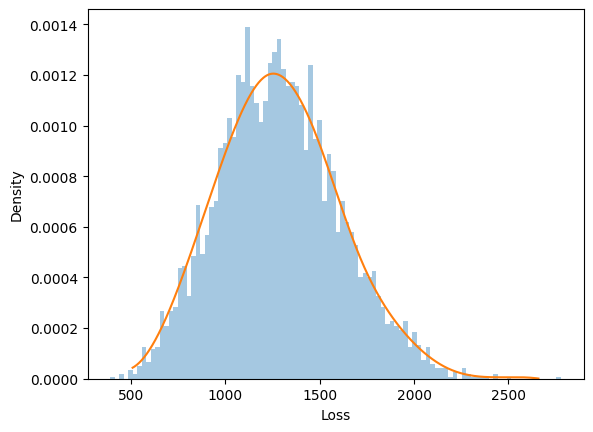

In [18]:
loan_l = [
    {
        "type": 'linear',
        "P": 10.0,
        "N": 12,
        "r": 0.12,
    }
    for i in range(N_firms)
]

losses_l = run_simulation(params, loan_l, num_trials=NUM_TRIALS)
metrics_l = compute_metrics(losses_l, alpha=0.95)
metrics_l_df = pd.DataFrame(metrics_l, index=['Linear'])
print(metrics_l_df)

loss_distribution_plot(losses_l, 'Linear amortisation')

In [19]:
concentratedsectors_df = pd.concat([metrics_b_df, metrics_f_df, metrics_l_df])
concentratedsectors_df

,Mean,Std,VaR,ES,Excess ES,ExcessKurtosis
Bullet,5885.982000,808.605835,7100.500000,7320.680000,220.180000,0.119520
French,1347.797183,338.077817,1928.877788,2097.959395,169.081607,0.055993
Linear,1287.381000,320.833390,1843.333333,1991.928951,148.595618,-0.037059


## Random sectoral weighing

In [20]:
rng = np.random.default_rng(1265883927568217)

N_firms = 1000
J = 3

c = 0.01

T = 1

NUM_TRIALS = 5000

kappa = rng.uniform(0.5, 1.5, J)
theta = rng.uniform(0.001, 0.051, J)
sigma_inter = rng.uniform(0.0, 0.2, J)
sigma = np.minimum(np.sqrt(2*kappa*theta), sigma_inter)

idio_factor = rng.uniform(0.01, 0.03, N_firms)

feller = (2 * kappa * theta) / (sigma**2)
print("Feller condition (should be >=1):", feller)

W = generate_portfolio_weights(N_firms, J, "random", rng=rng)

delta = c * W

lambda_benchmark = np.array([
    lambda_max_generator(1e-4, theta[j], theta[j],
                         sigma[j], kappa[j])
    for j in range(J)
])


params = {
    'Firms': N_firms,
    'Sectors': J,
    'Global Senstivity Param': c,
    'kappa': kappa,
    'theta': theta,
    'sigma': sigma,
    'delta': delta,
    'lambda_benchmark': lambda_benchmark,
    'idio_factor': idio_factor,
    'W': W,
    'T': T
}

Feller condition (should be >=1): [3.637663 4.700201 5.508869]


              Mean        Std         VaR          ES  Excess ES  \
Bullet 2291.426000 478.503027 3120.000000 3314.047619 194.047619   

        ExcessKurtosis  
Bullet       -0.092719  


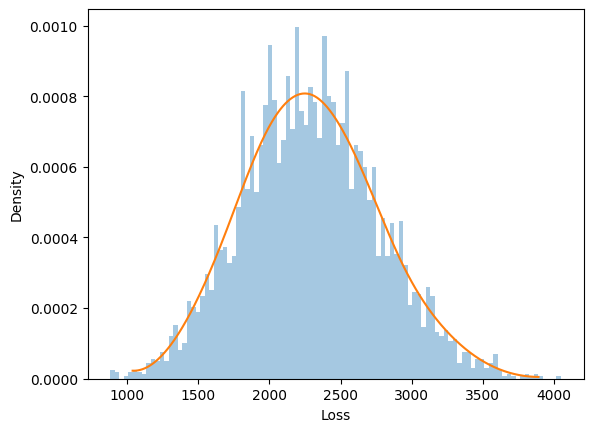

In [21]:
loan_b = [
    {
        "type": 'bullet',
        "P": 10.0,
        "N": 12,
        "r": 0.12,
    }
    for i in range(N_firms)
]

losses_b = run_simulation(params, loan_b, num_trials=NUM_TRIALS)
metrics_b = compute_metrics(losses_b, alpha=0.95)
metrics_b_df = pd.DataFrame(metrics_b, index=['Bullet'])
print(metrics_b_df)

loss_distribution_plot(losses_b, 'Bullet Loan')

             Mean        Std        VaR          ES  Excess ES  ExcessKurtosis
French 673.461204 154.772480 939.981747 1023.081508  83.099761        0.183185


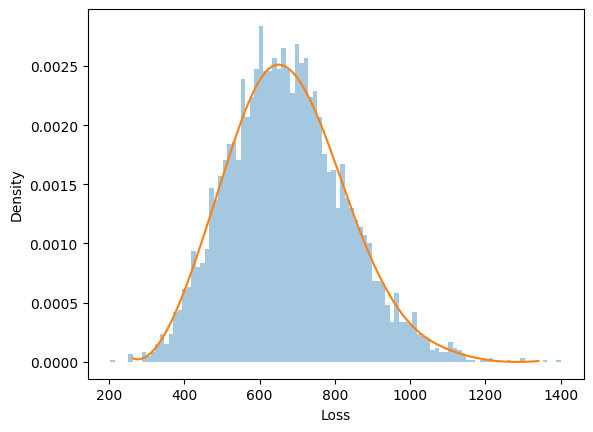

In [22]:
loan_f = [
    {
        "type": 'french',
        "P": 10.0,
        "N": 12,
        "r": 0.12,
    }
    for i in range(N_firms)
]

losses_f = run_simulation(params, loan_f, num_trials=NUM_TRIALS)
metrics_f = compute_metrics(losses_f, alpha=0.95)
metrics_f_df = pd.DataFrame(metrics_f, index=['French'])
print(metrics_f_df)

loss_distribution_plot(losses_f, 'French scheme')


             Mean        Std        VaR          ES  Excess ES  ExcessKurtosis
Linear 655.831833 150.478146 920.000000 1000.069444  80.069444        0.346255


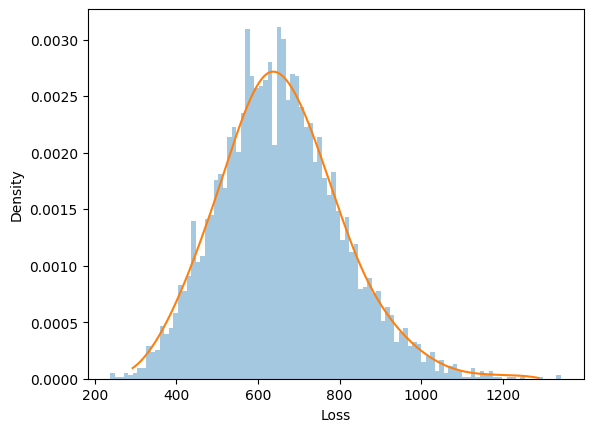

In [23]:
loan_l = [
    {
        "type": 'linear',
        "P": 10.0,
        "N": 12,
        "r": 0.12,
    }
    for i in range(N_firms)
]

losses_l = run_simulation(params, loan_l, num_trials=NUM_TRIALS)
metrics_l = compute_metrics(losses_l, alpha=0.95)
metrics_l_df = pd.DataFrame(metrics_l, index=['Linear'])
print(metrics_l_df)

loss_distribution_plot(losses_l, 'Linear scheme')

In [24]:
randomsectors_df = pd.concat([metrics_b_df, metrics_f_df, metrics_l_df])
randomsectors_df

,Mean,Std,VaR,ES,Excess ES,ExcessKurtosis
Bullet,2291.426000,478.503027,3120.000000,3314.047619,194.047619,-0.092719
French,673.461204,154.772480,939.981747,1023.081508,83.099761,0.183185
Linear,655.831833,150.478146,920.000000,1000.069444,80.069444,0.346255


## Mixed sectors

In [25]:
rng = np.random.default_rng(1265883927568217)

N_firms = 1000
J = 3

c = 0.01

T = 1

NUM_TRIALS = 5000

kappa = rng.uniform(0.5, 1.5, J)
theta = rng.uniform(0.001, 0.051, J)
sigma_inter = rng.uniform(0.0, 0.2, J)
sigma = np.minimum(np.sqrt(2*kappa*theta), sigma_inter)

idio_factor = rng.uniform(0.01, 0.03, N_firms)

feller = (2 * kappa * theta) / (sigma**2)
print("Feller condition (should be >=1):", feller)

W = generate_portfolio_weights(N_firms, J, "mixed", rng=rng)

delta = c * W

lambda_benchmark = np.array([
    lambda_max_generator(1e-4, theta[j], theta[j],
                         sigma[j], kappa[j])
    for j in range(J)
])


params = {
    'Firms': N_firms,
    'Sectors': J,
    'Global Senstivity Param': c,
    'kappa': kappa,
    'theta': theta,
    'sigma': sigma,
    'delta': delta,
    'lambda_benchmark': lambda_benchmark,
    'idio_factor': idio_factor,
    'W': W,
    'T': T
}

Feller condition (should be >=1): [3.637663 4.700201 5.508869]


              Mean        Std         VaR          ES  Excess ES  \
Bullet 3146.036000 612.873989 4180.000000 4429.126984 249.126984   

        ExcessKurtosis  
Bullet       -0.155733  


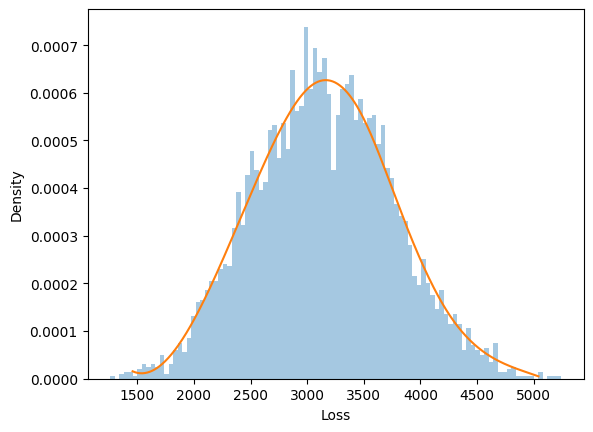

In [26]:
loan_b = [
    {
        "type": 'bullet',
        "P": 10.0,
        "N": 12,
        "r": 0.12,
    }
    for i in range(N_firms)
]

losses_b = run_simulation(params, loan_b, num_trials=NUM_TRIALS)
metrics_b = compute_metrics(losses_b, alpha=0.95)
metrics_b_df = pd.DataFrame(metrics_b, index=['Bullet'])
print(metrics_b_df)

loss_distribution_plot(losses_b, 'Bullet Loan')

             Mean        Std         VaR          ES  Excess ES  \
French 836.759168 195.369285 1176.233596 1286.942335 110.708739   

        ExcessKurtosis  
French        0.269580  


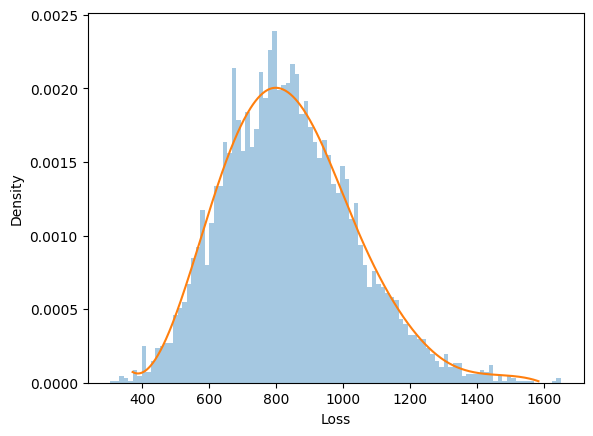

In [27]:
loan_f = [
    {
        "type": 'french',
        "P": 10.0,
        "N": 12,
        "r": 0.12,
    }
    for i in range(N_firms)
]

losses_f = run_simulation(params, loan_f, num_trials=NUM_TRIALS)
metrics_f = compute_metrics(losses_f, alpha=0.95)
metrics_f_df = pd.DataFrame(metrics_f, index=['French'])
print(metrics_f_df)

loss_distribution_plot(losses_f, 'French scheme')

             Mean        Std         VaR          ES  Excess ES  \
Linear 811.175167 189.166228 1144.208333 1230.356667  86.148334   

        ExcessKurtosis  
Linear        0.015711  


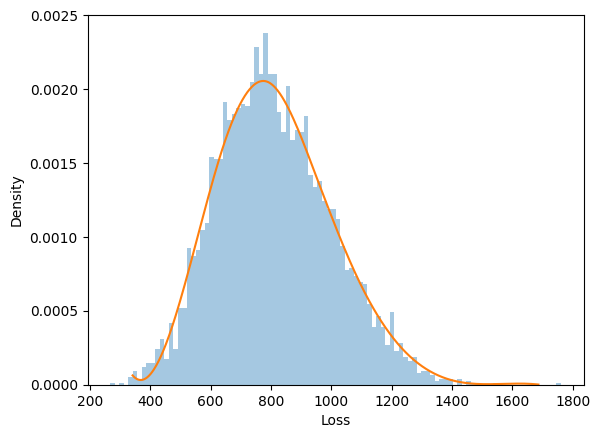

In [28]:
loan_l = [
    {
        "type": 'linear',
        "P": 10.0,
        "N": 12,
        "r": 0.12,
    }
    for i in range(N_firms)
]

losses_l = run_simulation(params, loan_l, num_trials=NUM_TRIALS)
metrics_l = compute_metrics(losses_l, alpha=0.95)
metrics_l_df = pd.DataFrame(metrics_l, index=['Linear'])
print(metrics_l_df)

loss_distribution_plot(losses_l, 'Linear scheme')

In [29]:
mixedsectors_df = pd.concat([metrics_b_df, metrics_f_df, metrics_l_df])
mixedsectors_df

,Mean,Std,VaR,ES,Excess ES,ExcessKurtosis
Bullet,3146.036000,612.873989,4180.000000,4429.126984,249.126984,-0.155733
French,836.759168,195.369285,1176.233596,1286.942335,110.708739,0.269580
Linear,811.175167,189.166228,1144.208333,1230.356667,86.148334,0.015711


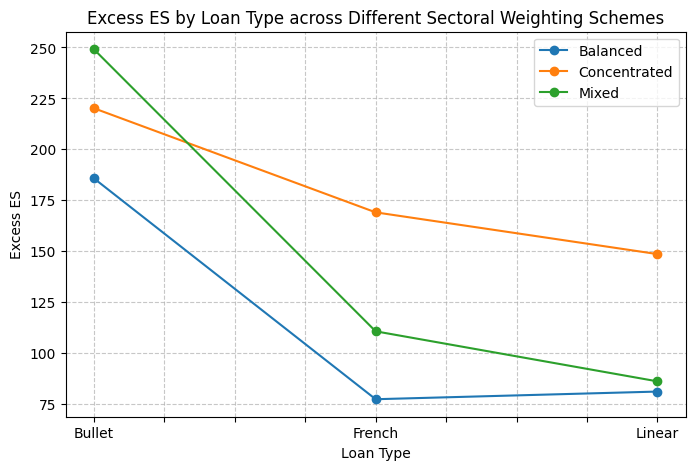

In [31]:
excess_es_df = pd.DataFrame({
    'Balanced': balancedsectors_df['Excess ES'],
    'Concentrated': concentratedsectors_df['Excess ES'],
    # 'Random': randomsectors_df['Excess ES'],
    'Mixed': mixedsectors_df['Excess ES']
})

ax = excess_es_df.plot(kind='line', marker='o', figsize=(8, 5))
ax.set_ylabel('Excess ES')
ax.set_xlabel('Loan Type')
ax.grid(linestyle='--', alpha=0.7)
plt.legend()
plt.title('Excess ES by Loan Type across Different Sectoral Weighting Schemes')
#plt.tight_layout()
plt.show()


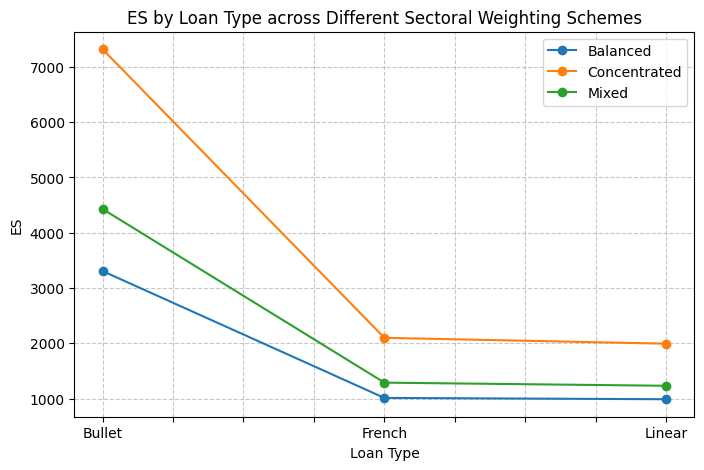

In [32]:
es_df = pd.DataFrame({
    'Balanced': balancedsectors_df['ES'],
    'Concentrated': concentratedsectors_df['ES'],
    # 'Random': randomsectors_df['Excess ES'],
    'Mixed': mixedsectors_df['ES']
})

ax = es_df.plot(kind='line', marker='o', figsize=(8, 5))
ax.set_ylabel('ES')
ax.set_xlabel('Loan Type')
ax.grid(linestyle='--', alpha=0.7)
plt.legend()
plt.title('ES by Loan Type across Different Sectoral Weighting Schemes')
#plt.tight_layout()
plt.show()


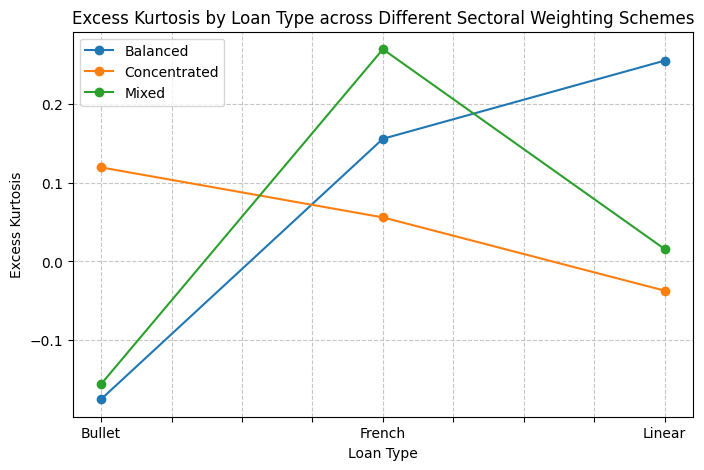

In [33]:
k_df = pd.DataFrame({
    'Balanced': balancedsectors_df['ExcessKurtosis'],
    'Concentrated': concentratedsectors_df['ExcessKurtosis'],
    # 'Random': randomsectors_df['ExcessKurtosis'],
    'Mixed': mixedsectors_df['ExcessKurtosis']
})

ax = k_df.plot(kind='line', marker='o', figsize=(8, 5))
ax.set_ylabel('Excess Kurtosis')
ax.set_xlabel('Loan Type')
ax.grid(linestyle='--', alpha=0.7)
plt.legend()
plt.title('Excess Kurtosis by Loan Type across Different Sectoral Weighting Schemes')
#plt.tight_layout()
plt.show()
